# Compare Coverage Ali HDF5 to anno file

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import socket as socket
import os as os
import sys as sys
import multiprocessing as mp
import h5py
import allel
from scipy.stats import sem

socket_name = socket.gethostname()
print(socket_name)

if socket_name.startswith("compute-"):
    print("HSM O2 Computational partition detected.")
    path = "/n/groups/reich/hringbauer/git/hapBLOCK/"  # The Path on Harvard Cluster
else: 
    raise RuntimeWarning("Not compatible machine. Check!!")

os.chdir(path)  # Set the right Path (in line with Atom default)

sys.path.append("./package/") 
from hapBLOCK.IO.h5_load import get_idx_iid_exact, get_coverage, get_markers_good
#from package.hapBLOCK.IO

print(os.getcwd())
print(f"CPU Count: {mp.cpu_count()}")

compute-a-16-46.o2.rc.hms.harvard.edu
HSM O2 Computational partition detected.
/n/groups/reich/hringbauer/git/hapBLOCK
CPU Count: 32


# Load processed Meta

In [2]:
df = pd.read_csv("/n/groups/reich/hringbauer/Data/v43.4.anno.csv")
print(f"Loaded {len(df)} samples")

df1 = df.loc[df["study"].str.contains("Marcus"), ["iid", "n_cov_snp", "avg_cov_snp"]].reset_index(drop=True)
print(f"Loaded Sardinian data: {len(df1)} Indvidiuals")

Loaded 18171 samples
Loaded Sardinian data: 70 Indvidiuals


In [7]:
df[df["iid"].str.contains("I12440|I13888")]

,iid,Master ID,lat,lon,age,region,study,clst,mean_cov,n_cov_snp,avg_cov_snp,include_alt,family,sex
7136,I13888,I13888,51.861211,-1.883011,5700.0,Great Britain,Unpublished (Nick Michael Britain BA to IA),England_N_Megalithic,0.665881,799057,2.851294,True,"Great Britain, England, Gloucestershire, Chelt...",F
8965,I12440,I12440,51.861211,-1.883011,5600.0,Great Britain,Unpublished (Nick Michael Britain BA to IA),England_N_Megalithic,0.588801,706561,2.142237,True,"Great Britain, England, Gloucestershire, Chelt...",M


## Generate Coverage for hdf5 sample
Use Sardinian data first

In [ ]:
f = h5py.File("./data/hdf5/1240k_v43/all_ch.h5", "r") # Load for Sanity Check. See below!

cs = []
for iid in df1["iid"].values[:]:
    print(f"Doing IID: {iid}")
    j1 = get_idx_iid_exact(f, iid)
    c = get_coverage(f, j1)
    cs.append(c)
f.close()

In [14]:
df1["cov_hdf5"]=cs

In [15]:
df1

,iid,n_cov_snp,avg_cov_snp,cov_hdf5
0,MA110,998177,4.513763,5.645104
1,SEC002,921909,2.462145,2.641236
2,ORC002,914199,2.372964,2.545004
3,MA89,895417,2.220946,2.528302
4,COR002,854222,1.947504,2.090046
...,...,...,...,...
65,S1250,43116,0.059023,0.072106
66,NOE001,39975,0.035465,0.038849
67,SUA005,37869,0.036213,0.039308
68,S1253,33521,0.037221,0.044069


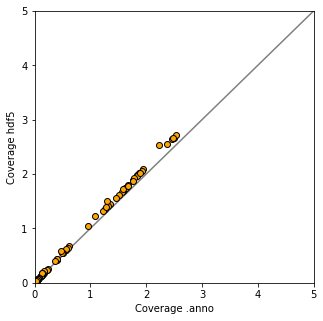

In [18]:
plt.figure(figsize=(5,5))
ax = plt.gca()
ax.scatter(df1["avg_cov_snp"].values.astype("float"), df1["cov_hdf5"].values, c="orange", ec="k")
ax.set_xlim([0,5])
ax.set_ylim([0,5])
ax.set_xlabel("Coverage .anno")
ax.set_ylabel("Coverage hdf5")
ax.plot([0,5],[0,5],c="gray",zorder=0)
plt.show()

In [10]:
f = h5py.File("./data/hdf5/1240k_v43/all_ch.h5", "r") # Load for Sanity Check. See below!
j1 = get_idx_iid_exact(f, "MA89")
get_coverage(f,j1)

2.528302401225833

# Test the weird samples

In [25]:
f = h5py.File("./data/hdf5/1240k_v43/all_ch.h5", "r") # Load for Sanity Check. See below!
j1 = get_idx_iid_exact(f, "I1293_all_d.SG")
print(get_coverage(f,j1))
j2 = get_idx_iid_exact(f, "I2312_all_d.SG")
print(get_coverage(f,j2))

0.17606172061949646
0.34355587909985613


In [33]:
ads = f["calldata/AD"][:,j1,:2]
ads[ads<0]=0
cov = np.sum(ads, axis=1)
np.sum(cov>0)

174518

In [34]:
ads = f["calldata/AD"][:,j2,:2]
ads[ads<0]=0
cov = np.sum(ads, axis=1)
np.sum(cov>0)

315528

In [31]:
df[df["iid"].str.contains("I1293_all_d.SG|I2312_all_d.SG")]

,iid,Master ID,lat,lon,age,region,study,clst,mean_cov,n_cov_snp,avg_cov_snp,include_alt,family
16599,I1293_all_d.SG,I1293,35.591,53.501,10800.0,Iran,Unpublished / Unclaimed (shotgun),Iran_Mesolithic_HotuIIIb_all.SG,0.021412,25694,..,True,n/a (no relatives detected)
16660,I2312_all_d.SG,I2312,35.590,53.500,11950.0,Iran,Unpublished / Unclaimed (shotgun),Iran_Mesolithic_BeltCave_d.SG,0.020155,24186,..,True,n/a (no relatives detected)


# Test whether weird samples have overlapping coverage

In [52]:
f = h5py.File("./data/hdf5/1240k_v43/all_ch.h5", "r") # Load for Sanity Check. See below!
j1 = get_idx_iid_exact(f, "I1293_all_d.SG")
print(get_coverage(f,j1))
j2 = get_idx_iid_exact(f, "I2312_all_d.SG")

0.17606172061949646


In [32]:
ads = f["calldata/AD"][:,[j1,j2],:2]
ads[ads<0]=0
print(np.shape(ads))
cov = np.sum(ads, axis=2)
cov1 = (cov>0).astype("int")

(1100313, 2, 2)


In [33]:
n_cov = cov1[:,0] + cov1[:,1]

In [34]:
pd.value_counts(n_cov)/len(n_cov)

0    0.604037
1    0.346556
2    0.049407
dtype: float64

In [45]:
a = np.mean(n_cov)/
print(a)

0.44536963573092386


In [48]:
np.mean(cov1,axis=0)  # Chance of coverage in each sample

array([0.1586076 , 0.28676204])

In [49]:
0.158*0.28676

0.04530808

### Check the heterozygosity of the indiviuals under question

In [7]:
f = h5py.File("./data/hdf5/1240k_v43/all_ch.h5", "r") # Load for Sanity Check. See below!
#m = get_markers_good(f, j1, output=False, cutoff=0.99)

In [8]:
def get_het(f, j, cutoff=0.99):
    """Get Heterozygosity for Markers above cutoff"""
    m = get_markers_good(f, j, output=False, cutoff=cutoff)
    gt1 = f["calldata/GT"][:, j, :][m,:]
    fac_het = np.mean(np.sum(gt1, axis=1)==1)
    return fac_het, gt1

In [11]:
j1 = get_idx_iid_exact(f, "I1293_all_d.SG")
fac_het, gt1 = get_het(f, j1, cutoff=0.98)
print(fac_het)
print(f"Mean derived {np.mean(gt1):.4f}")
len(gt1)

0.15257397066579292
Mean derived 0.1915


570733

In [14]:
j2 = get_idx_iid_exact(f, "I2312_all_d.SG")
fac_het, gt1 = get_het(f, j2, cutoff=0.99)
print(fac_het)
print(f"Mean derived {np.mean(gt1):.4f}")
len(gt1)

0.2599509060870698
Mean derived 0.2345


660367

In [133]:
j3 = get_idx_iid_exact(f, "SUC002")
fac_het, gt1 = get_het(f, j3, cutoff=0.99)
print(fac_het)
print(f"Mean derived {np.mean(gt1):.4f}")
len(gt1)

0.2327718757949667
Mean derived 0.2785


888402

In [87]:
j = get_idx_iid_exact(f, "MA89")
fac_het, gt1 = get_het(f, j, cutoff=0.99)
print(fac_het)
print(f"Mean derived {np.mean(gt1):.4f}")
len(gt1)

0.21497127930606336
Mean derived 0.2831


931036

In [135]:
j = get_idx_iid_exact(f, "SUC001")
fac_het, gt1 = get_het(f, j, cutoff=0.99)
print(fac_het)
print(f"Mean derived {np.mean(gt1):.4f}")

0.23421597712281636
Mean derived 0.2821


In [94]:
j = get_idx_iid_exact(f, "I18199")
fac_het, gt1 = get_het(f, j, cutoff=0.99)
print(fac_het)
print(f"Mean derived {np.mean(gt1):.4f}")

0.18437452084200381
Mean derived 0.2527


In [126]:
j = get_idx_iid_exact(f, "I1293_all_d.SG")
m = get_markers_good(f, j, output=False, cutoff=0.98)
ad = f["calldata/AD"][:, j, :][m,:2]
ad[ad<0]=0
cov = np.sum(ad, axis=1)
idx = (cov==2)
ad2 = ad[idx,:]
print(f"Extracted {len(ad2)} SNPs with Cov 2.")
h2 = np.mean(ad2[:,0]==1, axis=0)
print(f"Fraction Heterozygotes: {h2:.6f}")

Extracted 11216 SNPs with Cov 2.
Fraction Heterozygotes: 0.127407


In [ ]:
0.127 * 11216

In [146]:
def get_frac_hets(f, iid="I2312_all_d.SG"):
    """Estimate the Fraction of heterozygotes"""
    j = get_idx_iid_exact(f, iid)
    m = get_markers_good(f, j, output=False, cutoff=0.98)
    ad = f["calldata/AD"][:, j, :][m,:2]
    ad[ad<0]=0
    cov = np.sum(ad, axis=1)
    idx = (cov==2)
    ad2 = ad[idx,:]
    ad21 = ad2[:,0]==1
    h2 = np.mean(ad21)
    se = sem(ad21)
    print(f"Extracted {len(ad2)} SNPs with Cov 2.")
    print(f"Fraction Heterozygotes: {h2:.8f}")
    print(f"Standard Error: {se:.8f}")
    #return h2

In [149]:
get_frac_hets(f, iid="I1293_all_d.SG")

Extracted 11216 SNPs with Cov 2.
Fraction Heterozygotes: 0.12740728
Standard Error: 0.00314850


In [147]:
get_frac_hets(f, iid="I2312_all_d.SG")

Extracted 35117 SNPs with Cov 2.
Fraction Heterozygotes: 0.17270837
Standard Error: 0.00201713


In [150]:
get_frac_hets(f, iid="SUC002")

Extracted 155281 SNPs with Cov 2.
Fraction Heterozygotes: 0.13696460
Standard Error: 0.00087249


In [151]:
get_frac_hets(f, iid="COR002")

Extracted 179893 SNPs with Cov 2.
Fraction Heterozygotes: 0.13428538
Standard Error: 0.00080389


In [152]:
get_frac_hets(f, iid="SEC001")

Extracted 178365 SNPs with Cov 2.
Fraction Heterozygotes: 0.13046282
Standard Error: 0.00079751


In [153]:
get_frac_hets(f, iid="R67.SG")

Extracted 279273 SNPs with Cov 2.
Fraction Heterozygotes: 0.14088365
Standard Error: 0.00065833


In [154]:
get_frac_hets(f, iid="AH2.SG")

Extracted 145085 SNPs with Cov 2.
Fraction Heterozygotes: 0.12815935
Standard Error: 0.00087757


In [155]:
get_frac_hets(f, iid="AH1.SG")

Extracted 229894 SNPs with Cov 2.
Fraction Heterozygotes: 0.12738479
Standard Error: 0.00069536


In [156]:
get_frac_hets(f, iid="AH4.SG")

Extracted 194944 SNPs with Cov 2.
Fraction Heterozygotes: 0.12792392
Standard Error: 0.00075648


In [157]:
get_frac_hets(f, iid="WC1.SG")

Extracted 5673 SNPs with Cov 2.
Fraction Heterozygotes: 0.14101886
Standard Error: 0.00462128


In [158]:
get_frac_hets(f, iid="I1290")

Extracted 156350 SNPs with Cov 2.
Fraction Heterozygotes: 0.13210106
Standard Error: 0.00085633


In [160]:
get_frac_hets(f, iid="rath2.SG")

Extracted 277828 SNPs with Cov 2.
Fraction Heterozygotes: 0.13993550
Standard Error: 0.00065818


In [161]:
get_frac_hets(f, iid="Canes.SG")

Extracted 176301 SNPs with Cov 2.
Fraction Heterozygotes: 0.11774182
Standard Error: 0.00076760


In [162]:
get_frac_hets(f, iid="ZBC_IPB001.B-C0101_Luk2-Pinarbasi")

Extracted 155136 SNPs with Cov 2.
Fraction Heterozygotes: 0.10053115
Standard Error: 0.00076346


In [163]:
get_frac_hets(f, iid="ZHAJ_BON034.A0101_Luk9")

Extracted 102330 SNPs with Cov 2.
Fraction Heterozygotes: 0.12422554
Standard Error: 0.00103110


In [164]:
get_frac_hets(f, iid="I6767_all.SG")

Extracted 151662 SNPs with Cov 2.
Fraction Heterozygotes: 0.10969129
Standard Error: 0.00080245
